# Load Data



In [ ]:
from google.colab import drive
import pathlib
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
drive = pathlib.Path('./drive/MyDrive') / 'ML_Project' / 'Artwork-Detection-and-Style-Transfer-main'

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch.nn as nn
import cv2
import random
import torchvision.transforms as transforms
from torch.utils import data
from torch.nn import functional as F
from torchvision import models
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import numpy as np
import torch.optim as optim
import torchvision.datasets as td
from torchvision import transforms
from PIL import Image
from skimage.feature import hog as hog
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix,f1_score,recall_score,precision_score,balanced_accuracy_score

In [ ]:
##label for train,evaluate,test set###  int
ground_truth=[0]*193+[1]*193+[2]*193+[3]*198+[4]*195
evaluate_truth=[0]*3+[1]*3+[2]*3+[3]*3+[4]*3
test_truth=[0]*15+[1]*14+[2]*14+[3]*15+[4]*14

In [ ]:
len(test_truth)

72

In [ ]:
###define a train loader###
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class train_set(data.Dataset):
  def __init__ (self,root_path= drive / 'dataset'):
    self.image=[]
    self.label=ground_truth

    for i in range(1,973):
      ###(H,W,C)###
      img = cv2.imread(os.path.join(root_path, "image_total", "%07d.jpg" % i))
      if(i/100 in [1,2,3,4,5,6,7,8,9]):
        print(i/10,"%")
      self.image.append(img)

  def __len__(self):
    return len(self.label)

  def __getitem__(self, index):
     image=self.image[index]
     label=float(self.label[index])
     #pil_image=Image.fromarray(image.astype(np.uint8))

     output=preprocess(image)
     return output,label

#drive = pathlib.Path('./drive/MyDrive') / 'ML_Project' / 'Artwork-Detection-and-Style-Transfer-main'
Train_set=train_set()

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %


In [ ]:
len(Train_set)==len(Train_set.image)
Train_set[1][0].shape

torch.Size([3, 224, 224])

In [ ]:
###define evaluate_loader###
class evaluate_set():
  def __init__ (self,root_path= drive / 'dataset'):
    self.image=[]
    self.label=evaluate_truth

    for i in range(1,16):
      ###(H,W,C)###
      img = cv2.imread(os.path.join(root_path, "evaluate_image", "%03d.jpg" % i))
      self.image.append(img)

  def __len__(self):
    return len(self.label)

  def __getitem__(self, index):
     image=self.image[index]
     label=float(self.label[index])

     output=preprocess(image)
     return output,label

evaluate_set = evaluate_set()

In [ ]:
len(evaluate_set)==len(evaluate_set.image)

True

In [ ]:
###define test loader###
class test_set(data.Dataset):
  def __init__ (self,root_path= drive / 'dataset'):
    self.image=[]
    self.label=test_truth

    for i in range(72):
      ###(H,W,C)###
      img = cv2.imread(os.path.join(root_path, "new_test", "%03d.jpg" % i))
      self.image.append(img)

  def __len__(self):
    return len(self.label)

  def __getitem__(self, index):
     image=self.image[index]
     label=float(self.label[index])

     output=preprocess(image)
     return output,label
  
test_set=test_set()

In [ ]:
len(test_set)==len(test_set.image)

True

torch.Size([3, 224, 224])


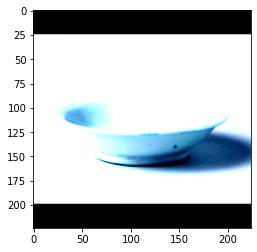

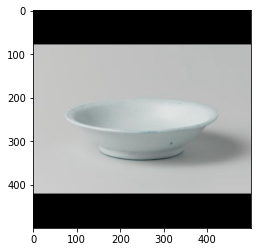

In [ ]:
###example of preprocess image and original image###
root_path= drive / 'dataset'
image,label=Train_set[1]
print(image.shape)
a=image.squeeze(0).numpy().transpose((1,2,0))
plt.imshow(a)
plt.show()
##(0-255) int###
img = cv2.imread(os.path.join(root_path, "image_total", "%07d.jpg" % 2))
plt.imshow(img)
plt.show()
#a

In [ ]:
###create related DataLoader###
train_loader=data.DataLoader(Train_set,batch_size=32,shuffle=True,drop_last=True,num_workers=2)
eva_loader=data.DataLoader(evaluate_set,batch_size=1,num_workers=2)
test_loader=data.DataLoader(test_set,batch_size=1,num_workers=2)

# Train Model

In [ ]:
###main train and evaluate function ###
def train_main(model,loss_fn,optimizer,train_loader,device):
  loss_epoch=[]
  for batchind,data in enumerate(train_loader):
    model.train()
    ##(b,c,h,w)
    images,label=data
    images = torch.Tensor(images).to(device)
    label = torch.Tensor(label).to(device)
    #print(images.shape)
    optimizer.zero_grad()
    outputs=model(images)
    ouputs=outputs.long()
    label=label.long()

    loss=loss_fn(outputs,label)
    loss_epoch.append(loss.item())

    loss.backward()
    optimizer.step()
  return loss_epoch

def evaluate_whole(model,evaluate_loader,evaluate_truth,device):
  predict_list=[]
  norm=nn.Softmax(1)
  model.eval()
  with torch.no_grad():
    for batchind,data in enumerate(evaluate_loader):
      images,label=data
      images = torch.Tensor(images).to(device)
      label = torch.Tensor(label).to(device).float()
      outputs=norm(model(images).detach().cpu()).numpy().ravel()
      predict_list.append(np.argmax(outputs))
  f1_c=f1_score(evaluate_truth,predict_list,average='micro')

  return predict_list,f1_c

# VGG

In [ ]:
##load pretrained VGG network ###
VGG=torch.hub.load('pytorch/vision:v0.8.2', 'vgg16', pretrained=True)
#VGG_new=nn.Sequential(*list(VGG.classifier.children())[:-1])
#VGG.classifier=VGG_new
#print(VGG)
VGG_new=nn.Sequential(
    *list(VGG.classifier.children())[:-1],
    nn.Linear(4096,5)
)
VGG.classifier=VGG_new
print(VGG)

Downloading: "https://github.com/pytorch/vision/zipball/v0.8.2" to /root/.cache/torch/hub/v0.8.2.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
###make a test###
for p in VGG.features.children():
  for params in p.parameters():
    params.requires_grad=False

for name, params in VGG.named_parameters():
  if params.requires_grad:
    print(name)

classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [ ]:
num_epoch=3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=VGG.to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(filter(lambda p:p.requires_grad,model.parameters()),lr=1e-4)

In [ ]:
### main train function###
train_loss=[]
evaluate_score=[]
for i in range(num_epoch):
  loss=train_main(model,loss_fn,optimizer,train_loader,device)
  train_loss.append(np.mean(loss))
  predict_r,f1_r=evaluate_whole(model,eva_loader,evaluate_truth,device)
  evaluate_score.append(f1_r)
  print(f'epoch{i+1} has been trained')

epoch1 has been trained
epoch2 has been trained
epoch3 has been trained


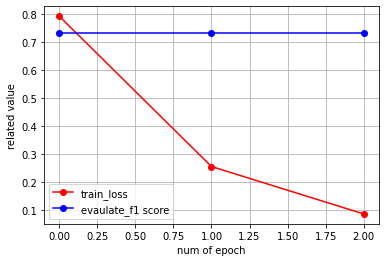

In [ ]:
### print train result and evaluation result###
plt.plot(train_loss,'o-r',label='train_loss')
plt.plot(evaluate_score,'o-b',label='evaulate_f1 score')
plt.xlabel('num of epoch')
plt.ylabel('related value')
plt.grid()
plt.legend()
plt.show()

In [ ]:
## the main test part ##
import seaborn as sns
from sklearn.metrics import confusion_matrix,f1_score,recall_score,precision_score,balanced_accuracy_score
def test_whole(model,test_loader,truth_label):
  predict_list=[]
  norm=nn.Softmax(1)
  model.eval()
  with torch.no_grad():
    for batchind,data in enumerate(test_loader):
      images,label=data
      images = torch.Tensor(images).to(device)
      label = torch.Tensor(label).to(device).float()
      outputs=norm(model(images).detach().cpu()).numpy().ravel()
      predict_list.append(np.argmax(outputs))
  f1_c=f1_score(truth_label,predict_list,average='micro')
  recall = recall_score(truth_label,predict_list,average='micro')
  prec = precision_score(truth_label,predict_list,average='micro')
  mac = balanced_accuracy_score(truth_label,predict_list)
  con_mat=confusion_matrix(truth_label,predict_list)

  return predict_list,f1_c,recall,prec,mac,con_mat

truth=test_set.label
predict_label,f1,recall,prec,mac,mat=test_whole(model,test_loader,truth)

the micro f1 score on test set is 0.7361111111111113
the micro recall score on test set is 0.7361111111111112
the micro precision score on test set is 0.7361111111111112
the micro mean average precision score on test set is 0.7361904761904763


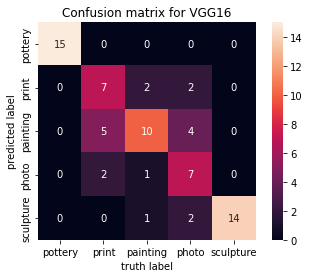

In [ ]:
print(f'the micro f1 score on test set is {f1}')
print(f'the micro recall score on test set is {recall}')
print(f'the micro precision score on test set is {prec}')
print(f'the micro mean average precision score on test set is {mac}')
label_name=['pottery','print','painting','photo','sculpture']
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=True,xticklabels=label_name,yticklabels=label_name)
#plt.colorbar()
plt.ylabel('predicted label')
plt.xlabel('truth label')
plt.title('Confusion matrix for VGG16')
plt.show()


In [ ]:
###save model's paramenters###
root_path = drive / "models" / "VGG"
path=os.path.join(root_path / 'model_paramenter_VGG_v1.txt')
torch.save(model.state_dict(),path)

path2=os.path.join(root_path / 'optimizer_paramenter_VGG_v1.txt')
torch.save(optimizer.state_dict(),path2)

# ResNet50

In [ ]:
##load pretrained resnet50 network ###
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
resnet50=nn.Sequential(
    resnet50,
    nn.Linear(1000,5)
)
print(resnet50)

/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(

  0%|          | 0.00/97.7M [00:00<?, ?B/s]

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layers): Sequential(
      (0): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        

In [ ]:
num_epoch=3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=resnet50.to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(filter(lambda p:p.requires_grad,model.parameters()),lr=1e-4)

In [ ]:
train_loss=[]
evaluate_score=[]
for i in range(num_epoch):
  loss=train_main(model,loss_fn,optimizer,train_loader,device)
  train_loss.append(np.mean(loss))
  predict_r,f1_r=evaluate_whole(model,eva_loader,evaluate_truth,device)
  evaluate_score.append(f1_r)
  print(f'epoch{i+1} has been trained')

epoch1 has been trained
epoch2 has been trained
epoch3 has been trained


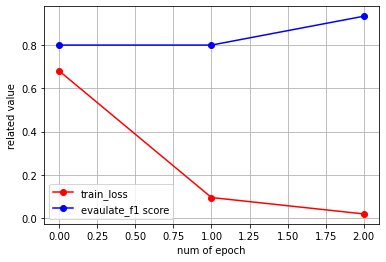

In [ ]:
### print train result and evaluation result###
plt.plot(train_loss,'o-r',label='train_loss')
plt.plot(evaluate_score,'o-b',label='evaulate_f1 score')
plt.xlabel('num of epoch')
plt.ylabel('related value')
plt.grid()
plt.legend()
plt.show()

In [ ]:
## the main test part ##
import seaborn as sns
from sklearn.metrics import confusion_matrix,f1_score
def test_whole(model,test_loader,truth_label):
  predict_list=[]
  norm=nn.Softmax(1)
  model.eval()
  with torch.no_grad():
    for batchind,data in enumerate(test_loader):
      images,label=data
      ##change to (1,c,h,w)
      images = torch.Tensor(images).to(device)
      label = torch.Tensor(label).to(device).float()
      outputs=norm(model(images).detach().cpu()).numpy().ravel()
      predict_list.append(np.argmax(outputs))
  f1_c=f1_score(truth_label,predict_list,average='micro')
  recall = recall_score(truth_label,predict_list,average='micro')
  prec = precision_score(truth_label,predict_list,average='micro')
  mac = balanced_accuracy_score(truth_label,predict_list)
  con_mat=confusion_matrix(truth_label,predict_list)
  con_mat=confusion_matrix(truth_label,predict_list)

  return predict_list,f1_c,recall,prec,mac,con_mat

truth=test_set.label
predict_label,f1,recall,prec,mac,mat=test_whole(model,test_loader,truth)
      

the micro f1 score on test set is 0.8472222222222222
the micro recall score on test set is 0.8472222222222222
the micro precision score on test set is 0.8472222222222222
the micro mean average precision score on test set is 0.8466666666666667


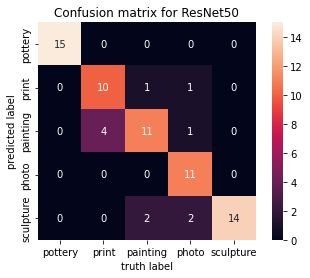

In [ ]:
print(f'the micro f1 score on test set is {f1}')
print(f'the micro recall score on test set is {recall}')
print(f'the micro precision score on test set is {prec}')
print(f'the micro mean average precision score on test set is {mac}')
label_name=['pottery','print','painting','photo','sculpture']
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=True,xticklabels=label_name,yticklabels=label_name)
#plt.colorbar()
plt.ylabel('predicted label')
plt.xlabel('truth label')
plt.title('Confusion matrix for ResNet50')
plt.show()

# AlexNet

In [ ]:
##load pretrained alexnet network ###
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alexnet=nn.Sequential(
    alexnet,
    nn.Linear(1000,5)
)
print(alexnet)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Sequential(
  (0): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1):

In [ ]:
num_epoch=3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=alexnet.to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(filter(lambda p:p.requires_grad,model.parameters()),lr=1e-4)

In [ ]:
train_loss=[]
evaluate_score=[]
for i in range(num_epoch):
  loss=train_main(model,loss_fn,optimizer,train_loader,device)
  train_loss.append(np.mean(loss))
  predict_r,f1_r=evaluate_whole(model,eva_loader,evaluate_truth,device)
  evaluate_score.append(f1_r)
  print(f'epoch{i+1} has been trained')

epoch1 has been trained
epoch2 has been trained
epoch3 has been trained


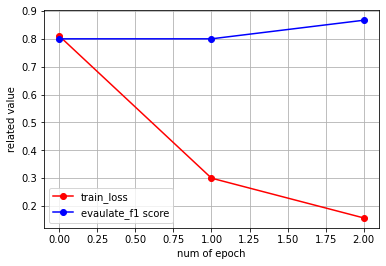

In [ ]:
### print train result and evaluation result###
plt.plot(train_loss,'o-r',label='train_loss')
plt.plot(evaluate_score,'o-b',label='evaulate_f1 score')
plt.xlabel('num of epoch')
plt.ylabel('related value')
plt.grid()
plt.legend()
plt.show()

In [ ]:
## the main test part ##
import seaborn as sns
from sklearn.metrics import confusion_matrix,f1_score
def test_whole(model,test_loader,truth_label):
  predict_list=[]
  norm=nn.Softmax(1)
  model.eval()
  with torch.no_grad():
    for batchind,data in enumerate(test_loader):
      images,label=data
      ##change to (1,c,h,w)
      images = torch.Tensor(images).to(device)
      label = torch.Tensor(label).to(device).float()
      outputs=norm(model(images).detach().cpu()).numpy().ravel()
      predict_list.append(np.argmax(outputs))
  f1_c=f1_score(truth_label,predict_list,average='micro')
  recall = recall_score(truth_label,predict_list,average='micro')
  prec = precision_score(truth_label,predict_list,average='micro')
  mac = balanced_accuracy_score(truth_label,predict_list)
  con_mat=confusion_matrix(truth_label,predict_list)

  return predict_list,f1_c,recall,prec,mac,con_mat

truth=test_set.label
predict_label,f1,recall,prec,mac,mat=test_whole(model,test_loader,truth)

the micro f1 score on test set is 0.8611111111111112
the micro recall score on test set is 0.8611111111111112
the micro precision score on test set is 0.8611111111111112
the micro mean average precision score on test set is 0.86


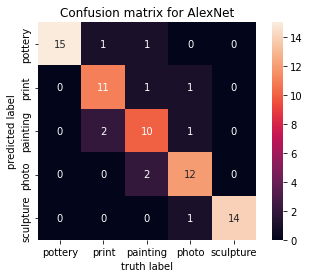

In [ ]:
print(f'the micro f1 score on test set is {f1}')
print(f'the micro recall score on test set is {recall}')
print(f'the micro precision score on test set is {prec}')
print(f'the micro mean average precision score on test set is {mac}')
label_name=['pottery','print','painting','photo','sculpture']
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=True,xticklabels=label_name,yticklabels=label_name)
#plt.colorbar()
plt.ylabel('predicted label')
plt.xlabel('truth label')
plt.title('Confusion matrix for AlexNet')
plt.show()

In [ ]:
import pickle
creators = []
with (open(drive / 'dataset' / 'label' / 'creator' / 'sample_creator_label.pickle', "rb")) as openfile:
    while True:
        try:
            creators.append(pickle.load(openfile))
        except EOFError:
            break
with (open(drive / 'dataset' / 'label' / 'creator' / 'test_creator_label.pickle', "rb")) as openfile:
    while True:
        try:
            creators.append(pickle.load(openfile))
        except EOFError:
            break
with (open(drive / 'dataset' / 'label' / 'creator' / 'val_creator_label.pickle', "rb")) as openfile:
    while True:
        try:
            creators.append(pickle.load(openfile))
        except EOFError:
            break
print(creators)
all_creators = {}
counter = 0
for c in creators[0]:
  for j in c:
    if j not in all_creators:
      all_creators[j] = 1
    else:
      all_creators[j] += 1
    counter += 1
print("length: ", len(all_creators))
print(all_creators)
print(counter)

[[['anoniem'], ['Dihl et Guerhard'], ['anoniem'], ['anoniem'], ['anoniem'], ['Amstel', 'Porceleinfabriek aan den'], ['anoniem'], ['anoniem'], ['anoniem'], ['anoniem'], ['Dihl et Guerhard'], ['anoniem'], ['anoniem'], ['anoniem'], ['anoniem'], [''], ['De Porceleijne Bijl'], ['anoniem'], [''], ['M.O.L.'], ['M.O.L.'], ['anoniem'], ['anoniem'], ['De Metalen Pot'], ['anoniem'], ['anoniem'], ['anoniem'], ['anoniem'], ['anoniem'], ['anoniem'], ['anoniem'], [''], ['anoniem'], ['anoniem'], ['anoniem'], ['anoniem'], ['anoniem'], ['Dihl et Guerhard'], ['anoniem'], ['anoniem'], ['anoniem'], ['De Porceleijne Bijl'], ['anoniem'], ['anoniem'], ['anoniem'], ['anoniem'], ['Swebach', 'Jacques François Joseph'], ['anoniem'], ['anoniem'], ['M.O.L.'], ['Dihl et Guerhard'], ['anoniem'], ['anoniem'], ['anoniem'], ['anoniem'], ['De Porceleijne Bijl'], [''], ['anoniem'], ['Fortuyn', "'t"], ['anoniem'], ['anoniem'], ['anoniem'], ['anoniem'], ['anoniem'], ['anoniem'], ['anoniem'], ['anoniem'], [''], ['anoniem'], 

# KNN

In [ ]:
### create knn data_loader and make related preprocess###
preprocess_knn = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
class train_set_knn(data.Dataset):
  def __init__ (self,root_path=drive / 'dataset'):
    self.image=[]
    self.label=ground_truth

    for i in range(1,973):
      ###(H,W,C)###
      img = cv2.imread(os.path.join(root_path, "image_total", "%07d.jpg" % i))
      self.image.append(img)

  def __len__(self):
    return len(self.label)

  def __getitem__(self, index):
     image=self.image[index]
     label=self.label[index]
     #pil_image=Image.fromarray(image.astype(np.uint8))

     return preprocess_knn(image),label

class eva_set_knn(data.Dataset):
  def __init__ (self,root_path=drive / 'dataset'):
    self.image=[]
    self.label=evaluate_truth

    for i in range(1,16):
      ###(H,W,C)###
      img = cv2.imread(os.path.join(root_path, "evaluate_image", "%03d.jpg" % i))
      self.image.append(img)

  def __len__(self):
    return len(self.label)

  def __getitem__(self, index):
     image=self.image[index]
     label=self.label[index]
     #pil_image=Image.fromarray(image.astype(np.uint8))

     return preprocess_knn(image),label
class test_set_knn(data.Dataset):
  def __init__ (self,root_path=drive / 'dataset'):
    self.image=[]
    self.label=test_truth

    for i in range(72):
      ###(H,W,C)###
      img = cv2.imread(os.path.join(root_path, "new_test", "%03d.jpg" % i))
      self.image.append(img)

  def __len__(self):
    return len(self.label)

  def __getitem__(self, index):
     image=self.image[index]
     label=self.label[index]
     #pil_image=Image.fromarray(image.astype(np.uint8))

     return preprocess_knn(image),label




In [ ]:
##construct 3 dataloader###
knn_train=train_set_knn()
knn_evaluate=eva_set_knn()
knn_test=test_set_knn()

In [ ]:
#a=hog(knn_train[1][0],multichannel=True)
#a.shape
c=np.transpose(knn_train[1][0].numpy(),(1,2,0))
type(c)
a=hog(c,multichannel=True)
a.shape
print(len(knn_test)==len(knn_test.label))

True


In [ ]:
#len(knn_train.image)==len(knn_train)
#len(knn_test.image)==len(knn_test)
###calculate hog features for KNN###

hog_train=np.zeros((972,54756))
hog_eva=np.zeros((15,54756))
hog_test=np.zeros((72,54756))
knn_train[1][0].shape

for i in range(hog_train.shape[0]):
  hog_train[i,:]=hog(np.transpose(knn_train[i][0].numpy(),(1,2,0)),multichannel=True)

for j in range(hog_eva.shape[0]):
  hog_eva[j,:]=hog(np.transpose(knn_evaluate[j][0].numpy(),(1,2,0)),multichannel=True)

for k in range(hog_test.shape[0]):
  hog_test[k,:]=hog(np.transpose(knn_test[k][0].numpy(),(1,2,0)),multichannel=True)


In [ ]:
hog_eval=np.zeros((45,54756))
for i in range(hog_eval.shape[0]):
  hog_eval[i,:]=hog(np.transpose(knn_train[(i+927)][0].numpy(),(1,2,0)),multichannel=True)

In [ ]:
len([i for i in range(928,973)])
q=[i for i in range(928,973)]
q[-1]
z=[i for i in range(1,21)]
z[1:5]

[2, 3, 4, 5]

the best n_neighbors is 10


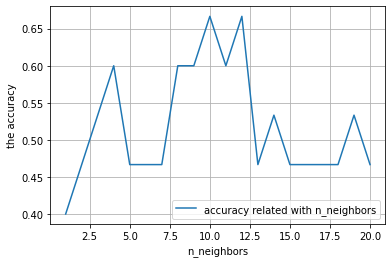

In [ ]:
### use evaluate set to find best hyperparameters###
mean_acc=[]
neighbor_list=[i for i in range(1,21)]
target=ground_truth
target_eval=evaluate_truth
for j in neighbor_list:
  KNN_model=KNeighborsClassifier(n_neighbors=j)
  KNN_model.fit(hog_train,target)
  mean_acc.append(KNN_model.score(hog_eva,target_eval))

plt.plot(neighbor_list,mean_acc,label='accuracy related with n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('the accuracy')
plt.grid()
plt.legend()
best_n=neighbor_list[np.argmax(mean_acc)]
print(f'the best n_neighbors is {best_n}')


the micro f1 score on test set is 0.5694444444444444
the micro recall score on test set is 0.5694444444444444
the micro precision score on test set is 0.5694444444444444
the micro mean average precision score on test set is 0.5666666666666667


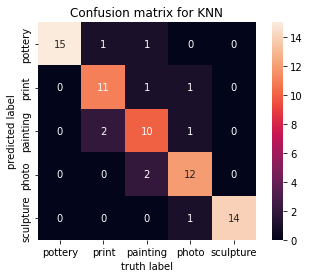

In [ ]:
###KNN model performance###
KNN_model=KNeighborsClassifier(n_neighbors=best_n)
KNN_model.fit(hog_train,target)
predict_list=KNN_model.predict(hog_test)

f1_c=f1_score(test_truth,predict_list,average='micro')

recall = recall_score(test_truth,predict_list,average='micro')
prec = precision_score(test_truth,predict_list,average='micro')
mac = balanced_accuracy_score(test_truth,predict_list)
con_mat=confusion_matrix(test_truth,predict_list)

print(f'the micro f1 score on test set is {f1_c}')
print(f'the micro recall score on test set is {recall}')
print(f'the micro precision score on test set is {prec}')
print(f'the micro mean average precision score on test set is {mac}')
label_name=['pottery','print','painting','photo','sculpture']
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=True,xticklabels=label_name,yticklabels=label_name)
#plt.colorbar()
plt.ylabel('predicted label')
plt.xlabel('truth label')
plt.title('Confusion matrix for KNN')
plt.show()